In [3]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas_ta as ta

from utils.labels import detect_head_and_shoulders, detect_double_bottom, label_patterns, create_windows
from utils.classify_window import classify_window
from utils.forecaster import forecaster
from model.CNN.CNN1D import CNN1D_MultiChannel
from model.CNN.CNN2D import CNN2D_MultiChannel
from trainers.CNN1DTrainer import CNN1DTrainer, TimeSeries1DDataset
from trainers.CNN2DTrainer import CNN2DTrainer, TimeSeries2DDataset


In [4]:
filepath = "data"
filename = "NIFTY 50_minute_data.csv"
# filename = "NIFTY 50_daily_data.csv"

file = f"{filepath}/{filename}"

df_nifty50_full = pd.read_csv(file)
df_nifty50_full.shape

(932946, 6)

In [5]:
df_nifty50 = df_nifty50_full[-100000:]

In [7]:
df_nifty50.loc[:, "ema"] = ta.ema(df_nifty50['close'], length=15)
df_nifty50.loc[:, "rsi"] = ta.rsi(df_nifty50['close'], length=15)
df_nifty50.loc[:, "zscore"] = ta.zscore(df_nifty50['close'], length=15)

df_nifty50.dropna(inplace=True)
df_nifty50.reset_index(drop=True, inplace=True)

# df['EMA'] = ta.ema(df['Close'], length=5)
# df['MACD'] = ta.macd(df['Close'])['MACD_12_26_9']
# df['RSI'] = ta.rsi(df['Close'], length=14)

/tmp/ipykernel_7794/2254231990.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nifty50.dropna(inplace=True)


In [8]:
df_nifty50.tail()

,date,open,high,low,close,volume,ema,rsi,zscore
99965,2025-02-07 15:25:00,23569.45,23570.60,23567.00,23568.10,0,23565.947842,60.730654,-0.686194
99966,2025-02-07 15:26:00,23568.10,23570.25,23565.30,23567.40,0,23566.129362,60.228034,-0.795776
99967,2025-02-07 15:27:00,23569.00,23578.35,23565.40,23576.50,0,23567.425691,64.338901,0.356366
99968,2025-02-07 15:28:00,23577.05,23578.60,23567.45,23568.10,0,23567.509980,58.371835,-0.729732
99969,2025-02-07 15:29:00,23568.10,23571.35,23557.35,23563.15,0,23566.964982,55.142854,-1.212804


In [9]:
WINDOW_SIZE = 10
PATTERN_LABELS = ['head_and_shoulders', 'double_bottom', 'ascending_triangle', 'none']

In [10]:
df_nifty_labelled = pd.DataFrame.from_dict(label_patterns(df_nifty50))

In [11]:
df_nifty_labelled.label.value_counts()

label
double_bottom         58452
none                  34186
ascending_triangle     5922
head_and_shoulders     1400
Name: count, dtype: int64

In [12]:

window_tensors, target = create_windows(df_nifty_labelled)
window_tensors[0]


tensor([[2.1755e+04, 2.1745e+04, 6.7741e+01, 1.7743e+00],
        [2.1754e+04, 2.1746e+04, 6.5720e+01, 1.3724e+00],
        [2.1755e+04, 2.1747e+04, 6.7037e+01, 1.3735e+00],
        [2.1756e+04, 2.1748e+04, 6.7571e+01, 1.2582e+00],
        [2.1767e+04, 2.1750e+04, 7.6561e+01, 2.3786e+00],
        [2.1780e+04, 2.1754e+04, 8.2836e+01, 2.7220e+00],
        [2.1782e+04, 2.1758e+04, 8.3464e+01, 2.1770e+00],
        [2.1790e+04, 2.1762e+04, 8.6033e+01, 2.1732e+00],
        [2.1802e+04, 2.1767e+04, 8.8595e+01, 2.2010e+00],
        [2.1802e+04, 2.1771e+04, 8.8595e+01, 1.8089e+00]])

In [13]:
window_tensors.shape

torch.Size([99960, 10, 4])

/home/yash/Gatech/deeplearning/omscs-capstone/trainers/CNN1DTrainer.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)  # e.g., (N, 15, 4) or (N, 4, 15)
/home/yash/Gatech/deeplearning/omscs-capstone/trainers/CNN1DTrainer.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.long)


torch.Size([79968, 4, 10])
torch.Size([19992, 4, 10])
Validation Loss: 0.6967 | Accuracy: 0.8066
Epoch [1/10], Loss: 0.7922, Accuracy: 0.7510
Validation Loss: 0.6383 | Accuracy: 0.8350
Epoch [2/10], Loss: 0.6442, Accuracy: 0.8391
Validation Loss: 0.5503 | Accuracy: 0.8917
Epoch [3/10], Loss: 0.5729, Accuracy: 0.8823
Validation Loss: 0.5233 | Accuracy: 0.9115
Epoch [4/10], Loss: 0.5313, Accuracy: 0.9060
Validation Loss: 0.5006 | Accuracy: 0.9219
Epoch [5/10], Loss: 0.5035, Accuracy: 0.9215
Validation Loss: 0.4780 | Accuracy: 0.9359
Epoch [6/10], Loss: 0.4842, Accuracy: 0.9329
Validation Loss: 0.4661 | Accuracy: 0.9414
Epoch [7/10], Loss: 0.4680, Accuracy: 0.9425
Validation Loss: 0.4639 | Accuracy: 0.9449
Epoch [8/10], Loss: 0.4570, Accuracy: 0.9484
Validation Loss: 0.4662 | Accuracy: 0.9430
Epoch [9/10], Loss: 0.4483, Accuracy: 0.9535
Validation Loss: 0.4581 | Accuracy: 0.9496
Epoch [10/10], Loss: 0.4409, Accuracy: 0.9579
Validation Loss: 0.4581 | Accuracy: 0.9496
✅ Model saved to: mode

/home/yash/Gatech/deeplearning/omscs-capstone/trainers/CNN1DTrainer.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_input, dtype=torch.float32)


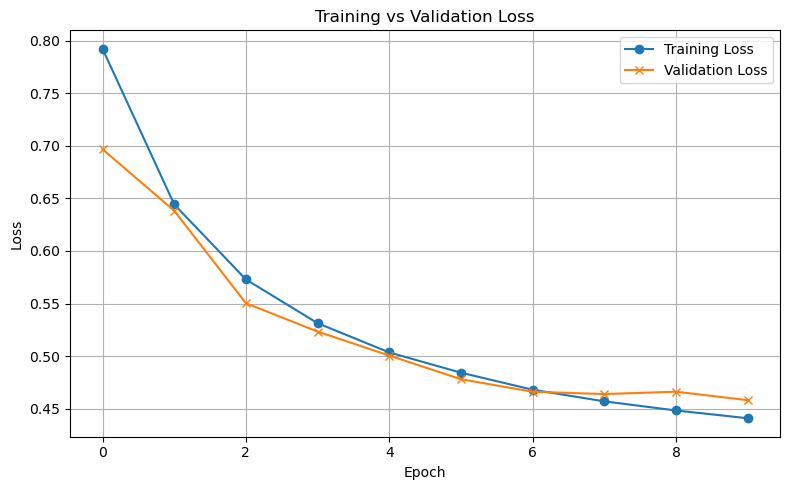

In [14]:
# window_tensors_CNN2D = window_tensors.transpose(0, 2, 1).reshape(-1, 4, 5, 3)

X_train, X_val, y_train, y_val = train_test_split(window_tensors, target, test_size=0.2)

model = CNN1D_MultiChannel(num_classes=4)

trainer = CNN1DTrainer(model, X_train, y_train, X_val, y_val, batch_size=32, lr=1e-3)

trainer.train(num_epochs=10)
trainer.evaluate()

trainer.save_model("models_results/checkpoints/CNN1D_MULTICHANNEL.pt")

predictions = trainer.predict(X_val[:5])
print("Predicted classes:", predictions)

trainer.plot_losses()


In [15]:
predictions = trainer.predict(X_val[:2])
print("Predicted classes:", list(predictions))

Predicted classes: [3, 3]


/home/yash/Gatech/deeplearning/omscs-capstone/trainers/CNN2DTrainer.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
/home/yash/Gatech/deeplearning/omscs-capstone/trainers/CNN2DTrainer.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long)


Validation Loss: 0.8097 | Accuracy: 0.7522
Epoch [1/10] | Train Loss: 0.8989 | Val Loss: 0.8097 | Train Acc: 0.6901
Validation Loss: 0.6917 | Accuracy: 0.8145
Epoch [2/10] | Train Loss: 0.7495 | Val Loss: 0.6917 | Train Acc: 0.7822
Validation Loss: 0.6367 | Accuracy: 0.8484
Epoch [3/10] | Train Loss: 0.6696 | Val Loss: 0.6367 | Train Acc: 0.8263
Validation Loss: 0.6100 | Accuracy: 0.8610
Epoch [4/10] | Train Loss: 0.6172 | Val Loss: 0.6100 | Train Acc: 0.8569
Validation Loss: 0.5661 | Accuracy: 0.8860
Epoch [5/10] | Train Loss: 0.5822 | Val Loss: 0.5661 | Train Acc: 0.8759
Validation Loss: 0.5612 | Accuracy: 0.8910
Epoch [6/10] | Train Loss: 0.5575 | Val Loss: 0.5612 | Train Acc: 0.8917
Validation Loss: 0.5443 | Accuracy: 0.8992
Epoch [7/10] | Train Loss: 0.5402 | Val Loss: 0.5443 | Train Acc: 0.9015
Validation Loss: 0.5272 | Accuracy: 0.9058
Epoch [8/10] | Train Loss: 0.5278 | Val Loss: 0.5272 | Train Acc: 0.9083
Validation Loss: 0.5206 | Accuracy: 0.9095
Epoch [9/10] | Train Loss: 0.

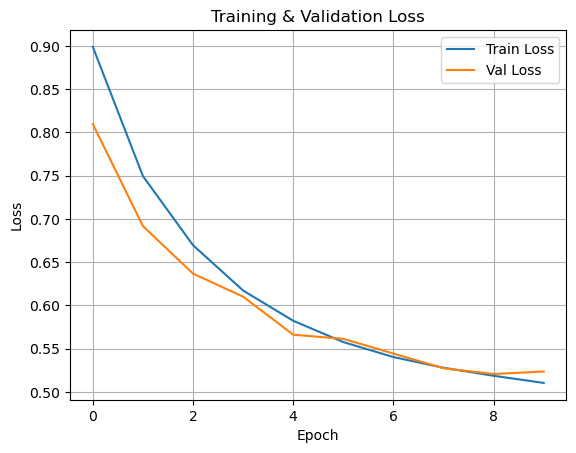

In [16]:
model = CNN2D_MultiChannel(in_channels=4, num_classes=4)
trainer = CNN2DTrainer(model, X_train, y_train, X_val, y_val, batch_size=32, lr=1e-3)
trainer.train(num_epochs=10)
trainer.evaluate()
trainer.save_model("models_results/checkpoints/CNN2D_MULTICHANNEL.pt")
trainer.plot_losses()

In [18]:

classify_window(window_tensors[12], model_type='2d', model_path="models_results/checkpoints/CNN2D_MULTICHANNEL.pt", PATTERN_LABELS=PATTERN_LABELS)

'double_bottom'

In [69]:
class CNN1D_SingleChannel(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN1D_SingleChannel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(64, 128, kernel_size=3)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        # Compute the flattened size from window size = 15
        # Conv1: 15 → 13, Pool1: 13 → 6
        # Conv2: 6 → 4, Pool2: 4 → 2
        self.flattened_size = 128 

        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        # Expecting input shape (batch, 1, 15)
        x = self.pool1(F.relu(self.conv1(x)))  # → (B, 64, 6)
        x = self.pool2(F.relu(self.conv2(x)))  # → (B, 128, 2)
        x = x.view(x.size(0), -1)              # → (B, 256)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

In [75]:
class TimeSeries1DDataset(Dataset):
    def __init__(self, X, y, normalize=True):
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.long)

        # Ensure correct shape: (batch_size, 1, 15)
        if X.ndim == 2:
            X = X.unsqueeze(1)  # from (N, 15) → (N, 1, 15)
        elif X.ndim == 3 and X.shape[1] != 1:
            raise ValueError(f"Expected input with 1 channel. Got shape: {X.shape}")

        # Normalize per-window
        if normalize:
            mean = X.mean(dim=2, keepdim=True)
            std = X.std(dim=2, keepdim=True) + 1e-8
            X = (X - mean) / std

        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class CNN1DTrainer:
    def __init__(self, model, X_train, y_train, X_val, y_val,
                 num_classes=4, batch_size=32, lr=1e-3, device=None):
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.train_losses = []
        self.val_losses = []
        self.train_loader = DataLoader(
            TimeSeries1DDataset(X_train, y_train, normalize=True),
            batch_size=batch_size, shuffle=True
        )
        
        self.val_loader = DataLoader(
            TimeSeries1DDataset(X_val, y_val, normalize=True),
            batch_size=batch_size, shuffle=False
        )

    def train(self, num_epochs=10):
        self.model.train()
        for epoch in range(num_epochs):
            total_loss = 0
            total_samples = 0
            all_preds = []
            all_targets = []

            for X_batch, y_batch in self.train_loader:
                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device)

                outputs = self.model(X_batch)
                loss = self.criterion(outputs, y_batch)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item() * X_batch.size(0)
                total_samples += X_batch.size(0)

                preds = torch.argmax(outputs, dim=1)
                all_preds.append(preds.cpu())
                all_targets.append(y_batch.cpu())
            
            avg_loss = total_loss / total_samples
            train_acc = accuracy_score(torch.cat(all_targets), torch.cat(all_preds))
            
            val_loss = self.evaluate(return_loss=True)
            self.train_losses.append(avg_loss)
            self.val_losses.append(val_loss)
            
            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {train_acc:.4f}")

    def evaluate(self, return_loss=False):
        self.model.eval()
        all_preds = []
        all_targets = []
        total_loss = 0.0
        total_samples = 0

        with torch.no_grad():
            for X_batch, y_batch in self.val_loader:
                X_batch = X_batch.to(self.device)
                y_batch = y_batch.to(self.device)

                outputs = self.model(X_batch)
                loss = self.criterion(outputs, y_batch)

                total_loss += loss.item() * X_batch.size(0)
                total_samples += X_batch.size(0)
                
                preds = torch.argmax(outputs, dim=1)
                all_preds.append(preds.cpu())
                all_targets.append(y_batch.cpu())

        avg_val_loss = total_loss / total_samples
        val_acc = accuracy_score(torch.cat(all_targets), torch.cat(all_preds))
        print(f"Validation Loss: {avg_val_loss:.4f} | Accuracy: {val_acc:.4f}")
        
        if return_loss:
            return avg_val_loss
        return val_acc

    def predict(self, X_input):
        """
        Predict class labels for new input data.
        X_input shape: (N, 1, 15)  # batch, channels, window_size
        """
        self.model.eval()
        X_tensor = torch.tensor(X_input, dtype=torch.float32).to(self.device)

        with torch.no_grad():
            outputs = self.model(X_tensor)
            preds = torch.argmax(outputs, dim=1)
        return preds.cpu().numpy()

In [63]:
def detect_head_and_shoulders(close_prices, tolerance=0.03):
    peaks, _ = find_peaks(close_prices)
    if len(peaks) < 3:
        return False

    # Look for three peaks (left, head, right)
    for i in range(len(peaks) - 2):
        left, head, right = peaks[i], peaks[i + 1], peaks[i + 2]
        if head - left > 2 and right - head > 2:  # spacing
            l, h, r = close_prices[left], close_prices[head], close_prices[right]
            if h > l and h > r:
                if abs(l - r) / h < tolerance:
                    return True
    return False


def detect_double_bottom(close_prices, PEAK_PROMINENCE=0.01):
    troughs, _ = find_peaks(-close_prices)
    if len(troughs) < 2:
        return False

    for i in range(len(troughs) - 1):
        t1, t2 = troughs[i], troughs[i + 1]
        if abs(t1 - t2) < 3:
            continue  # too close

        v1, v2 = close_prices[t1], close_prices[t2]
        mid = close_prices[t1:t2].max()

        if abs(v1 - v2) / mid < PEAK_PROMINENCE and mid > v1 and mid > v2:
            return True
    return False


def detect_ascending_triangle(close_prices, PEAK_PROMINENCE=0.01):
    peaks, _ = find_peaks(close_prices)
    troughs, _ = find_peaks(-close_prices)
    if len(peaks) < 2 or len(troughs) < 2:
        return False

    # Check if resistance line is flat and lows are rising
    top_diff = max(close_prices[peaks]) - min(close_prices[peaks])
    low_diffs = np.diff(close_prices[troughs])
    if top_diff / close_prices[peaks[-1]] < PEAK_PROMINENCE and np.all(low_diffs > 0):
        return True
    return False

def label_patterns_singleattr(df, window_size=10, target_attribute='close'):
    labels = []
    windows = []
    for i in range(len(df) - window_size):

        window = df.iloc[i:i + window_size][target_attribute]
        values = window.values

        if detect_head_and_shoulders(values):
            label = 'head_and_shoulders'
        elif detect_double_bottom(values):
            label = 'double_bottom'
        elif detect_ascending_triangle(values):
            label = 'ascending_triangle'
        else:
            label = 'none'
        windows.append({"window": window, "label": label})
    return windows

In [64]:
df_nifty50.iloc[0:1 + 10]['close'].values

array([21754.85, 21753.85, 21755.1 , 21755.6 , 21766.65, 21780.25,
       21782.05, 21790.5 , 21801.9 , 21801.9 , 21814.05])

In [65]:
df_nifty_labelled_single_attr = pd.DataFrame.from_dict(label_patterns_singleattr(df_nifty50))

In [66]:
df_nifty_labelled_single_attr

,window,label
0,0 21754.85 1 21753.85 2 21755.10 3 ...,none
1,1 21753.85 2 21755.10 3 21755.60 4...,none
2,2 21755.10 3 21755.60 4 21766.65 5...,none
3,3 21755.60 4 21766.65 5 21780.25 6...,none
4,4 21766.65 5 21780.25 6 21782.05 7...,none
...,...,...
99955,99955 23586.65 99956 23589.80 99957 2...,ascending_triangle
99956,99956 23589.80 99957 23582.60 99958 2...,ascending_triangle
99957,99957 23582.60 99958 23562.85 99959 2...,ascending_triangle
99958,99958 23562.85 99959 23575.60 99960 2...,double_bottom


In [67]:
window_tensors_1d, target_1d = create_windows(df_nifty_labelled, target_cols=['close'])
window_tensors_1d[0]


tensor([[21754.8496],
        [21753.8496],
        [21755.0996],
        [21755.5996],
        [21766.6504],
        [21780.2500],
        [21782.0508],
        [21790.5000],
        [21801.9004],
        [21801.9004]])

In [76]:

X_train1d, X_val1d, y_train1d, y_val1d = train_test_split(window_tensors_1d, target_1d, test_size=0.2, random_state=42)
X_train1d = X_train1d.permute(0, 2, 1)
X_val1d = X_val1d.permute(0, 2, 1)


model = CNN1D_SingleChannel(num_classes=4)

trainer = CNN1DTrainer(model, X_train1d, y_train1d, X_val1d, y_val1d, batch_size=32, lr=1e-3)

trainer.train(num_epochs=10)
trainer.evaluate()

predictions = trainer.predict(X_val1d[:])
print("Predicted classes:", predictions)

/tmp/ipykernel_7794/2102059033.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32)
/tmp/ipykernel_7794/2102059033.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long)


Validation Loss: 0.4907 | Accuracy: 0.7956
Epoch [1/10], Loss: 0.6293, Accuracy: 0.7407
Validation Loss: 0.3826 | Accuracy: 0.8458
Epoch [2/10], Loss: 0.4304, Accuracy: 0.8250
Validation Loss: 0.3029 | Accuracy: 0.8764
Epoch [3/10], Loss: 0.3449, Accuracy: 0.8620
Validation Loss: 0.2622 | Accuracy: 0.8940
Epoch [4/10], Loss: 0.2907, Accuracy: 0.8846
Validation Loss: 0.2293 | Accuracy: 0.9066
Epoch [5/10], Loss: 0.2498, Accuracy: 0.9012
Validation Loss: 0.2115 | Accuracy: 0.9157
Epoch [6/10], Loss: 0.2207, Accuracy: 0.9124
Validation Loss: 0.1946 | Accuracy: 0.9249
Epoch [7/10], Loss: 0.1977, Accuracy: 0.9224
Validation Loss: 0.1903 | Accuracy: 0.9270
Epoch [8/10], Loss: 0.1782, Accuracy: 0.9299
Validation Loss: 0.1863 | Accuracy: 0.9282
Epoch [9/10], Loss: 0.1632, Accuracy: 0.9365
Validation Loss: 0.2091 | Accuracy: 0.9202
Epoch [10/10], Loss: 0.1486, Accuracy: 0.9426
Validation Loss: 0.2091 | Accuracy: 0.9202
Predicted classes: [3 3 3 3 3]


/tmp/ipykernel_7794/2102059033.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_input, dtype=torch.float32).to(self.device)


In [83]:
predictions = trainer.predict(X_val1d[0:100])

/tmp/ipykernel_7794/2102059033.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_tensor = torch.tensor(X_input, dtype=torch.float32).to(self.device)


In [84]:
predictions

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])